In [24]:
raise Exception("kick out of document generation scripts")

Exception: kick out of document generation scripts

# Dry Lab Data Generation

Dry Lab: 

1. *A dry lab is a laboratory where computational or applied mathematical analyses are done on a computer-generated model to simulate a phenomenon in the physical realm.* - https://en.wikipedia.org/wiki/Dry_lab
2. *To dry lab is to make up data in a scientific experiment, as opposed to observe or experiment in order to obtain it. Usually this is done in response to pressures to finish the experiment by unethical researchers.* - https://www.urbandictionary.com/define.php?term=dry%20lab

Providing useful, usable examples of big MDF data analytics requires 'big data'. If company would like to host/sponsor some public data it would be extremely helpful.

In the meantime, some fake signal generators.

## Dry Lab Config

The fake channels, companies and products to generate data for.

In [14]:
import random
import uuid
import copy
import asammdf
import numpy as np
import os
import io
import fsspec

channels = {
    "engine_speed": "rpm",
    "engine_speed_desired": "rpm",
    "vehicle_speed": "kph",
    "coolant_temp": "C",
    "longitude": "",
    "latitude": "",
    "power": "W",
    "efficiency": "W",
    "ADAS5_failure": "bool",
    "X": "",
    "Y": "",
    "Z": "",
}

companies = [
    "DäsCarGmbh",
    "HeavyEquipmentInc",
    "DanishStartup",
    "ABMøøse",
    "재벌",
]
products = [
    "Car",
    "IndustrialEngine",
    "Bulldozer",
    "DumpTruck",
    "Excavator",
    "Transmission",
    "BoatyMcBoatface",
    "MarsColonizer",
]

Simplified signal generators to use for channel signal:

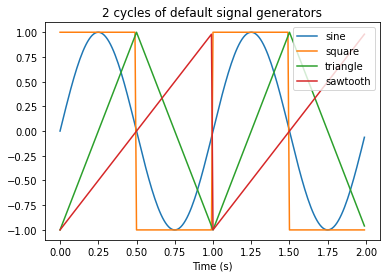

In [15]:
import scipy as sp
import scipy.signal
# Simplified signals
def sine(t, A=1, f=1):
    sine_ = A * np.sin(
        2 * np.pi * f * t
    )
    return sine_
def square(t, A=1, f=1):
    square_ = A * scipy.signal.square(
        2 * np.pi * f * t
    )
    return square_
def triangle(t, A=1, f=1):
    triangle_ = A * sp.signal.sawtooth(2 * np.pi * f * t, width=0.5)
    return triangle_
def sawtooth(t, A=1, f=1):
    sawtooth_ = A * sp.signal.sawtooth(2 * np.pi * f * t, width=1)
    return sawtooth_
signal_generators = [sine, square, triangle, sawtooth]

%matplotlib inline
import matplotlib.pyplot as plt
f=100
T0=0
Tf=2
t = np.arange(T0, Tf, 1/f)
for signal_generator in signal_generators:
    plt.plot(t, signal_generator(t))
plt.legend([sg.__name__ for sg in signal_generators], loc="upper right")
plt.xlabel("Time (s)")
plt.title("2 cycles of default signal generators");

Configure the specifics of the MDF file settings:

In [16]:
# Versions of MDF to save data as.
# TODO: Add in the other versions, there is currently a bug saving to a fsspec file system.
versions = [
    '4.00',
    '4.10',
    '4.11',
]

In [17]:
# How much data should be in each MDF file?
Tfs = [86400, 86400/2, 86400/4, 86400/12] # [s] "Big" data. Does not work on binder
Tfs = [60, 600, 1800] # [s] "Tiny" data.
# What is the sampling rate of the data?
Tss = [1, 0.1, 0.01] # [s]

In [18]:
# S3 FS 
s3_cfg = {
    "key": "minio",
    "secret": "miniostorage",
    "client_kwargs": {
        "endpoint_url": "http://127.0.0.1:9000",
    },
}
import fsspec
# Use S3
#fs = fsspec.filesystem("s3", **s3_cfg)
#buckets = fs.ls("")

In [19]:
# Use local file system (faster) for generating data.
import os
try:
    os.chdir("mdf_data/")
except FileNotFoundError:
    pass
fs = fsspec.filesystem("file")

buckets = [
    bucket
    for bucket in fs.ls("")
    if fs.isdir(bucket)
]

In [20]:
if len(buckets)==0:
    for bucket in range(10):
        try:
            bucket=f"mdfbucket-{bucket}"
            fs.mkdir(bucket)
        except FileExistsError:
            pass    

# Signals Generator

Generate signals for the MDF file.

In [9]:
def drylab_signals():
    
    # Randomly pick sampling rate and total log duration from the lists
    Tf = random.choice(Tfs)
    Ts = random.choice(Tss)
    
    # Create a timestamps vector.
    timestamps = np.arange(0, Tf, Ts, dtype=np.float32)
    
    
    ## Introduce Errors to logs.
    # Code written to generate "bad" data so we can
    # Write code to find bad data
    
    # Channel dropout, randomly leave channels out of the MDF.
    channels2 = copy.deepcopy(channels) 
    if random.random()<0.025:
        dropped_channel = random.choice(list(channels2.keys()))
        channels2.pop(dropped_channel)
    if random.random()<0.025:
        dropped_channel = random.choice(list(channels2.keys()))
        channels2.pop(dropped_channel)
    if random.random()<0.025:
        dropped_channel = random.choice(list(channels2.keys()))
        channels2.pop(dropped_channel)
    
    signals = list()
    for channel_name, channel_unit in channels2.items():
        # Where is the data centered?
        loc = random.choice([250, 500, 750, 1000])
        # How much is the data scaled?
        scale = random.choice([10, 25, 50, 100])
        A = np.random.normal(loc,scale)
        f = np.abs(np.random.normal(1/(Ts*10), 1))
        
        # Randomly flatline a signal at a random number.
        if random.random()<0.05:
            Y=np.ones(np.size(timestamps))*random.choice([0, 500, 1000])
        else:
            Y = signal_generator(timestamps, A, f)
        # Randomly insert chunks of bad data 
        if random.random()<0.05:
            # How man
            bad_samples = random.randint(0, len(Y))
            bad_idx = random.randint(0, len(Y)-bad_samples)
            Y[bad_idx:bad_idx+bad_samples]=random.choice([0, 1000])

        signal_ = asammdf.Signal(
            samples=Y,
            timestamps=timestamps,
            name=channel_name,
            unit=channel_unit,
        )
        signals.append(signal_)
    return signals

# MDF Generator

Generate an MDF file.

In [10]:
def drylab_mdf(*args, **kwargs):
    # Randomly pick a bucket to save to.
    bucket  = random.choice(buckets)
    # Randomly pick a company name the MDF belongs to.
    company = random.choice(companies)
    product = random.choice(products)
    # Globally unique mdf filename.
    data_file_uuid = str(uuid.uuid4())
    
    # Randomly pick a MDF version.
    version = random.choice(versions)
    
    # Get the datafile path.
    datafile = os.path.join(
        bucket,
        company,
        product,
        data_file_uuid
    )
    # Determine what suffix the datafile should have.
    if version.startswith("4"):
        datafile+=".mf4"
    else:
        datafile+=".mdf"
        
    # Make the directory the MDF is going to go into.
    fs.makedir(os.path.dirname(datafile))
    # Open a datafile on the filesystem in binary write mode.
    with fs.open(datafile, mode="wb") as fid:
        # Workaround since asammdf can't write files to s3fs directly right now.
        with io.BytesIO() as buffer:
            # Create an MDF.
            mdf = asammdf.MDF(version=version)
            # Add a set of drylab signals to it
            # with a common timebase
            mdf.append(
                signals=drylab_signals(),
                common_timebase=True,
            )
            # Save the file
            mdf.save(
                dst=fid,
                compression=2,
            )
            fid.write(buffer.getvalue())

In [11]:
from multiprocessing import Pool

In [21]:
%%timeit
# Number of MDF files to generate.
n = 8
# Number of cores to use to generate MDF files.
p = Pool(8)
p.map(drylab_mdf, range(n))

723 ms ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Generate MDFs until canceled:

In [13]:
while True:
    try:
        p.map(drylab_mdf, range(64))
    except:
        break